In [1]:
import tensorflow as tf
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import cv2

import warnings
warnings.filterwarnings('ignore')

***Data Preprocessing and Loading Data***

In [3]:
# Input Shape
shape = (175,175,1)

In [4]:
# To Detect Faces
haarCascade = cv2.CascadeClassifier('./utils/face_detection.xml')
def faceDetect(img):
    facesDetected = haarCascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=3)

    face = []
    for (x,y,w,h) in facesDetected:
        face = img[y:y+h, x:x+w]

    return np.array(face)

def plot_image(image, title):
    print(image.shape)
    plt.title(title)
    plt.imshow(image)

In [5]:
dir = './dataset'
dataset = 1

images = np.load(f'./{dir}/d{dataset}_images.npy').astype(np.float32)/255.0
persons = np.load(f'./{dir}/d{dataset}_persons.npy')

(175, 175, 1)


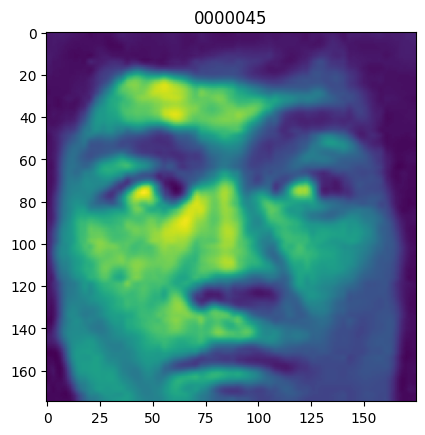

In [6]:
plot_image(images[0], persons[0][0])

***Model Architecture***

In [7]:
# Embedding Size
embeddingSize = 256

# L2 Normalization Layer
@keras.saving.register_keras_serializable()
class L2NormalizationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return tf.linalg.l2_normalize(inputs, axis=1)

    def get_config(self):
        return super().get_config()

# Convolution Block
@keras.saving.register_keras_serializable()
class ConvBlock(keras.layers.Layer):
    def __init__(self, filters,regularizer=None,**kwargs):
        super(ConvBlock, self).__init__(**kwargs)
        self.filters = filters
        self.regularizer = regularizer
        self.conv1 = keras.layers.Conv2D(filters=int(filters/2), kernel_size=(3, 3), activation='relu', padding='same')
        self.conv2 = keras.layers.Conv2D(filters=int(filters/2), kernel_size=(3, 3), activation='relu', padding='same')
        self.conv3 = keras.layers.Conv2D(filters=int(filters/2), kernel_size=(3, 3), activation='relu', padding='same')
        self.conv4 = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv5 = keras.layers.Conv2D(filters=filters, kernel_size=(3, 3), activation='relu', padding='same')
        self.conv = keras.layers.Conv2D(filters=filters*2, kernel_size=(1, 1), activation='relu', kernel_regularizer=regularizer)
        self.pool = keras.layers.MaxPooling2D(pool_size=(2, 2))

    def call(self, inputs):
        x1 = self.conv1(inputs)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = keras.layers.Concatenate()([x1, x3])
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        x = keras.layers.Concatenate()([x, x5])
        x = self.conv(x)
        return self.pool(x)

    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters, 'regularizer': self.regularizer})

        return config

# Triplet Loss Fucntion
@keras.saving.register_keras_serializable()
class TripletLoss(keras.losses.Loss):
    def __init__(self, alpha=0.25, name='triplet_loss',**kwargs):
        super(TripletLoss, self).__init__(name=name,**kwargs)
        self.alpha = alpha

    def call(self, y_true, y_pred):
        anchorEmbed = y_pred[:, :embeddingSize]
        positiveEmbed = y_pred[:, embeddingSize:embeddingSize*2]
        negativeEmbed = y_pred[:, embeddingSize*2:]

        # Calculate Cosine Similarity
        # positiveSimilarity = tf.reduce_sum(anchorEmbed * positiveEmbed, axis=-1)
        # negativeSimilarity = tf.reduce_sum(anchorEmbed * negativeEmbed, axis=-1)

        # Calculate Euclidean Distance
        positiveDistance = tf.reduce_sum(tf.square(anchorEmbed - positiveEmbed), axis=-1)
        negativeDistance = tf.reduce_sum(tf.square(anchorEmbed - negativeEmbed), axis=-1)

        loss = tf.maximum(positiveDistance - negativeDistance + self.alpha, 0.0)
        # loss = tf.maximum(negativeSimilarity - positiveSimilarity + self.alpha, 0.0)
        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({'alpha': self.alpha})

        return config

keras.saving.get_custom_objects()

{'Custom>L2NormalizationLayer': __main__.L2NormalizationLayer,
 'Custom>ConvBlock': __main__.ConvBlock,
 'Custom>TripletLoss': __main__.TripletLoss}

In [8]:
ConvNet= keras.models.Sequential([
    ConvBlock(filters=64),
    keras.layers.BatchNormalization(),
    ConvBlock(filters=128),
    keras.layers.BatchNormalization(),
    ConvBlock(filters=256),
    keras.layers.BatchNormalization(),
    ConvBlock(filters=512),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(embeddingSize),
    L2NormalizationLayer(),
], name='Conv_Net')

anchorInputs = keras.layers.Input(shape=shape, name='Anchor_Input')
positiveInputs = keras.layers.Input(shape=shape, name='Positive_Input')
negativeInputs = keras.layers.Input(shape=shape, name='Negative_Input')

anchorEmbed = ConvNet(anchorInputs)
positiveEmbed = ConvNet(positiveInputs)
negativeEmbed = ConvNet(negativeInputs)

outputs = keras.layers.Concatenate(axis=1)([anchorEmbed, positiveEmbed, negativeEmbed])

siameseNet = keras.Model([anchorInputs, positiveInputs, negativeInputs], outputs)

siameseNet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Anchor_Input        │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Positive_Input      │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Negative_Input      │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_Net            │ (None, 256)       │ 219,462,8… │ Anchor_Input[0][… │
│ (Sequential)        │                   │            │ Positive_Input[0… │
│                     │                   │            │ Negative_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 768)       │          0 │ Conv_Net[0][0],   │
│ (Concatenate)       │                   │            │ Conv_Net[1][0],   │
│                     │                   │            │ Conv_Net[2][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 219,462,848 (837.18 MB)

 Trainable params: 219,459,008 (837.17 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [9]:
embeddingInput = keras.layers.Input(shape=shape, name='Embedding_Input')
ConvNet = siameseNet.get_layer('Conv_Net')
embeddings = ConvNet(embeddingInput)

embeddingModel = keras.models.Model(embeddingInput, embeddings)
embeddingModel.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Input (InputLayer)    │ (None, 175, 175, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Net (Sequential)           │ (None, 256)            │   219,462,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,462,848 (837.18 MB)

 Trainable params: 219,459,008 (837.17 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [10]:
siameseNet = keras.saving.load_model('./models/face_recog.keras')
siameseNet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Anchor_Input        │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Positive_Input      │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Negative_Input      │ (None, 175, 175,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv_Net            │ (None, 256)       │ 219,462,8… │ Anchor_Input[0][… │
│ (Sequential)        │                   │            │ Positive_Input[0… │
│                     │                   │            │ Negative_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 768)       │          0 │ Conv_Net[0][0],   │
│ (Concatenate)       │                   │            │ Conv_Net[1][0],   │
│                     │                   │            │ Conv_Net[2][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 658,380,866 (2.45 GB)

 Trainable params: 219,459,008 (837.17 MB)

 Non-trainable params: 3,840 (15.00 KB)

 Optimizer params: 438,918,018 (1.64 GB)

In [11]:
embeddingModel = keras.saving.load_model('./models/embeddings.keras')
embeddingModel.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Embedding_Input (InputLayer)    │ (None, 175, 175, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_Net (Sequential)           │ (None, 256)            │   219,462,848 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,462,848 (837.18 MB)

 Trainable params: 219,459,008 (837.17 MB)

 Non-trainable params: 3,840 (15.00 KB)

***Generating Triplets & Model Inputs***

In [12]:
# Training Split
trainSplit = 0.7

def randomTriplets(batch_size=8, split='train', search=10):
    anchors = np.zeros((batch_size,shape[0],shape[1],shape[2]))
    positives = np.zeros((batch_size,shape[0],shape[1],shape[2]))
    negatives = np.zeros((batch_size,shape[0],shape[1],shape[2]))

    if(split=='train'):
        length = int(trainSplit*len(images))
        splitImages = images[:length]
        splitPersons = persons[:length]
    else:
        length = int(trainSplit*len(images))
        splitImages = images[length:]
        splitPersons = persons[length:]

    for i in range(batch_size):
        anchorIdx = np.random.randint(0,splitImages.shape[0]-1)
        person = splitPersons[anchorIdx]

        anchorEmbed = embeddingModel.predict(splitImages[anchorIdx].reshape(-1,shape[0],shape[1],shape[2]), verbose=None)

        posDist = 0.0
        posIdx = anchorIdx
        pos = np.where(splitPersons==person)[0]
        for j in range(search):
            idx = np.random.choice(pos)
            positiveEmbed = embeddingModel.predict(splitImages[idx].reshape(-1,shape[0],shape[1],shape[2]), verbose=None)
            dist = np.linalg.norm(anchorEmbed-positiveEmbed)
            if(dist>posDist):
                posDist = dist
                posIdx = idx

        negDist = 5e9
        negIdx = anchorIdx
        neg = np.where(splitPersons!=person)[0]
        for j in range(search):
            idx = np.random.choice(neg)
            negativeEmbed = embeddingModel.predict(splitImages[idx].reshape(-1,shape[0],shape[1],shape[2]), verbose=None)
            dist = np.linalg.norm(anchorEmbed-negativeEmbed)
            if(dist<negDist):
                negDist = dist
                negIdx = idx

        anchors[i] = splitImages[anchorIdx]
        positives[i] = splitImages[posIdx]
        negatives[i] = splitImages[negIdx]

    return anchors, positives, negatives

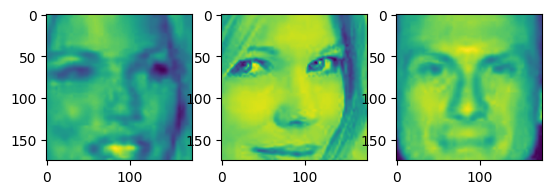

In [13]:
anchors, positives, negatives = randomTriplets(batch_size=1)

plt.subplot(1,3,1)
plt.imshow(anchors[0])
plt.subplot(1,3,2)
plt.imshow(positives[0])
plt.subplot(1,3,3)
plt.imshow(negatives[0])

***Data Generator & Model Compilation***

In [14]:
# Defining Data Generator
def dataGenerator(batch_size=8, split="train", search=5):
    while True:
        x = randomTriplets(batch_size, split,search)
        y = np.zeros((batch_size,3*embeddingSize))
        yield x,y

# Alpha (For Triplet-Loss)
alpha = 0
# Learning Rate
lr = 5e-4
# Batch Size
batchSize = 2
# Training Steps
stepsPerEpoch = int(0.1*trainSplit*len(images)/batchSize)
# Validation Steps
valSteps = int(0.1*(1-trainSplit)*len(images)/batchSize)
# Epochs
epochs = 50

# Callbacks
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=lr)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [15]:
loss = TripletLoss(alpha)
optimizer = keras.optimizers.AdamW(learning_rate=lr)

siameseNet.compile(loss=loss, optimizer=optimizer)

In [ ]:
history = siameseNet.fit(dataGenerator(batchSize, split='train', search=5), steps_per_epoch=stepsPerEpoch, epochs=epochs, validation_data=dataGenerator(batchSize, split='validation', search=5), validation_steps=valSteps, callbacks=[reduceLR,earlyStopping])

570/570 ━━━━━━━━━━━━━━━━━━━━ 1566s 3s/step - loss: 0.3007 - val_loss: 0.3000 - learning_rate: 5.0000e-04


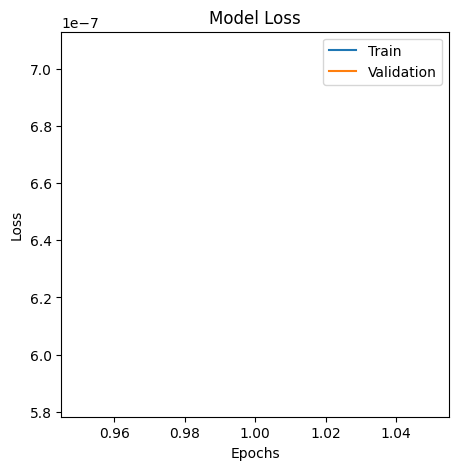

In [ ]:
plt.figure(figsize=(5,5))
modelLoss = history.history['loss']
modelValLoss = history.history['val_loss']
plt.plot(range(1,len(modelLoss)+1), modelLoss)
plt.plot(range(1,len(modelValLoss)+1), modelValLoss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'])
plt.title("Model Loss")
plt.show()

***Creating Embeddings Model & Saving***

In [19]:
embeddingInput = keras.layers.Input(shape=shape, name='Embedding_Input')
ConvNet = siameseNet.get_layer('Conv_Net')
embeddings = ConvNet(embeddingInput)

embeddingModel = keras.models.Model(embeddingInput, embeddings)
embeddingModel.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Embedding_Input (InputLayer)         │ (None, 175, 175, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv_Net (Sequential)                │ (None, 256)                 │     219,462,848 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 219,462,848 (837.18 MB)

 Trainable params: 219,459,008 (837.17 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [20]:
keras.saving.save_model(siameseNet, './models/face_recog.keras')
keras.saving.save_model(embeddingModel,'./models/embeddings.keras')

***Creating Database***

In [16]:
model = keras.saving.load_model('./models/embeddings.keras')

In [17]:
path = './database/images'

database = pd.DataFrame(columns=['Person','Embeddings'])

index = 0
for person in os.listdir(path):
    for img in os.listdir(os.path.join(path,person)):
        imgPath = os.path.join(path,person,img)
        image = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2GRAY)
        face = faceDetect(image)

        if(face.shape[0]==0):
            print(person, "Error")
            continue

        inputs = cv2.resize(face, (shape[0],shape[1]), interpolation=cv2.INTER_CUBIC)
        inputs = np.array(inputs).reshape(-1,shape[0],shape[1],shape[2])/255.0
        print(inputs.shape)
        embeddings = model.predict(inputs)

        database.loc[len(database)] = [person, embeddings[0]]

        print(person, "Done")

database.to_parquet('./database/database.parquet')
database.head()

(1, 175, 175, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Dev_Patel Done
(1, 175, 175, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Dhruv_Lad Done
(1, 175, 175, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Jay_Parikh Done
(1, 175, 175, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Viren_Goswami Done


,Person,Embeddings
0,Dev_Patel,"[-0.0097505525, -0.09307164, -0.03997265, -0.0..."
1,Dhruv_Lad,"[-0.011152088, -0.09339485, -0.03912313, -0.07..."
2,Jay_Parikh,"[-0.00806119, -0.09403521, -0.040891383, -0.07..."
3,Viren_Goswami,"[-0.007259476, -0.09439983, -0.041260432, -0.0..."


***Face Recognition***

In [21]:
name = 'Dev_Patel'
path = f'./database/images/{name}/{name}.jpg'
path = './Dev Patel.jpg'
print(path)

haarCascade = cv2.CascadeClassifier('./utils/face_detection.xml')

image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
detection = haarCascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=4)

for (x,y,w,h) in detection:
    face = image[y:y+h,x:x+w]

inputs = cv2.resize(face, (shape[0],shape[1]), interpolation=cv2.INTER_CUBIC)
inputs = np.array(inputs).reshape(-1,shape[0],shape[1],shape[2])/255.0
outputs = model.predict([inputs])[0]

./Dev Patel.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


In [22]:
def dist(a,b):
    return (np.linalg.norm(a-b))**2

In [24]:
database = pd.read_parquet('./database/database.parquet')

minDist = 0.1
identity = "Cannot Recognise"
for index, row in database.iterrows():
    embeddings = row['Embeddings']
    person = row['Person']

    distance = dist(outputs, embeddings)
    print(person,distance)
    if distance < minDist:
        identity = person
        minDist = distance

# Threshold
threshold = 0.01
if minDist > threshold:
    identity = "Cannot Recognise"

print(identity)

Dev_Patel 0.0014648872009754982
Dhruv_Lad 0.0019876671625560505
Jay_Parikh 0.0010749899838293775
Viren_Goswami 0.00022488458593929173
Viren_Goswami
